In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 指定系统中已安装的中文字体，例如SimSun或Microsoft YaHei
plt.rcParams['font.family'] = 'SimSun'

# 如果您需要显示中文标签，可以设置以下参数
plt.rcParams['axes.unicode_minus'] = False  # 处理坐标轴负号显示问题

In [3]:
df = pd.read_excel('data/raw_data.xlsx', skiprows=0) 

In [4]:
del df['Unnamed: 0']

In [6]:
df['day_of_the week'] = pd.to_datetime(df['date']).dt.dayofweek
df['date_normalize'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d') 

def label_day_of_the_week(row):    
    if row['day_of_the week'] == 0:
        return 'Monday'
    if row['day_of_the week'] == 1:
        return 'Tuesday'
    if row['day_of_the week'] == 2:
        return 'Wednesday'
    if row['day_of_the week'] == 3:
        return 'Thursday'
    if row['day_of_the week'] == 4:
        return 'Friday'
    if row['day_of_the week'] == 5:
        return 'Saturday'
    if row['day_of_the week'] == 6:
        return 'Sunday'


def is_holiday(row):
    if row['day_of_the week'] == 'Sunday':
        return 1
    else:
        return 0
df['day_of_the week'] = df.apply(lambda row: label_day_of_the_week(row), axis=1)
df['is_holiday'] = df.apply(lambda row: is_holiday(row), axis=1)


def polish_label_holidays(row):    
    if row['is_holiday'] == 0 and (row['date_normalize']=='2018-01-01' or row['date_normalize']=='2018-01-06'
    or row['date_normalize']=='2018-04-01' or row['date_normalize']=='2018-04-02' or row['date_normalize']=='2018-05-01' 
    or row['date_normalize']=='2018-05-03' or row['date_normalize']=='2018-05-31' or row['date_normalize']=='2018-08-15' 
    or row['date_normalize']=='2018-11-01' or row['date_normalize']=='2018-11-11' or row['date_normalize']=='2018-12-25' 
    or row['date_normalize']=='2018-12-26' or row['date_normalize']=='2019-01-01' or row['date_normalize']=='2019-01-06'
    or row['date_normalize']=='2019-04-21' or row['date_normalize']=='2019-04-22' or row['date_normalize']=='2019-05-01'
    or row['date_normalize']=='2019-05-03' or row['date_normalize']=='2019-06-09' or row['date_normalize']=='2019-06-20'
    or row['date_normalize']=='2019-08-15' or row['date_normalize']=='2019-11-01' or row['date_normalize']=='2019-11-11'
    or row['date_normalize']=='2019-12-25' or row['date_normalize']=='2019-12-26' or row['date_normalize']=='2020-01-01'
    or row['date_normalize']=='2020-01-06' or row['date_normalize']=='2020-04-12' or row['date_normalize']=='2020-04-13'
    or row['date_normalize']=='2020-05-01' or row['date_normalize']=='2020-05-03' or row['date_normalize']=='2020-06-11'
    or row['date_normalize']=='2020-08-15' or row['date_normalize']=='2020-11-11' or row['date_normalize']=='2020-12-25'
    or row['date_normalize']=='2020-12-26'):
        return 1
    
    if row['is_holiday'] == 1:
        return 1
    else:
        return 0
   

def label_hour(row):     
    if row['hour'] >= 6 and row['hour'] <= 22:
        return 1    
    else:
        return 0   
    
df['is_holiday'] = df.apply(lambda row: polish_label_holidays(row), axis=1)
df['hour'] = df.date.dt.hour
df['code_of_the_day'] = df.apply(lambda row: label_hour(row), axis=1)




In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27335 entries, 0 to 27334
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           27335 non-null  datetime64[ns]
 1   electricity_price (PLN/MWh)    27335 non-null  float64       
 2   energy_demand (MW)             27335 non-null  int64         
 3   energy_from_wind_sources (MW)  27335 non-null  int64         
 4   date_normalize                 27335 non-null  object        
 5   is_holiday                     27335 non-null  int64         
 6   hour                           27335 non-null  int64         
 7   code_of_the_day                27335 non-null  int64         
 8   day_of_the week                27335 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 1.9+ MB


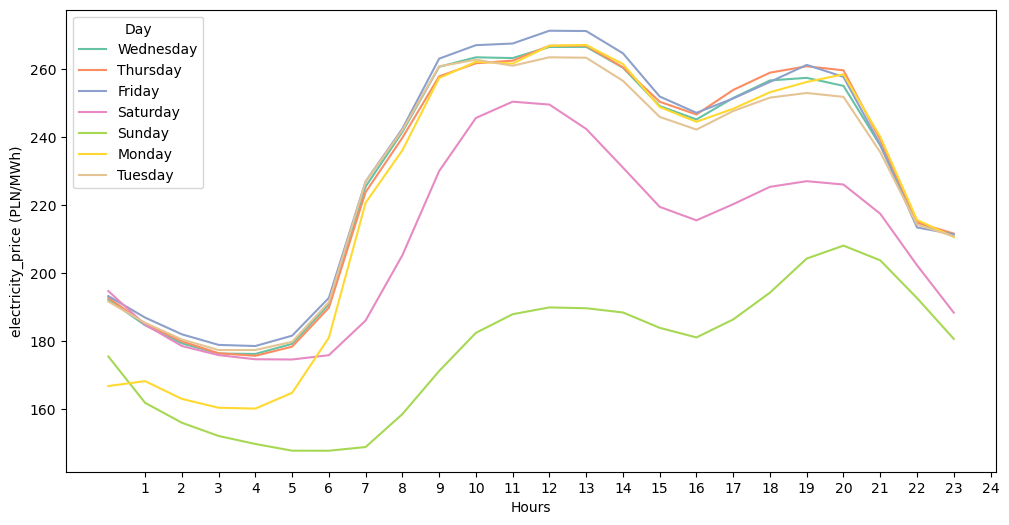

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 根据日期和星期几进行分组，并计算每天每小时的电力价格平均值
df_grouped = df.groupby(['day_of_the week', 'hour'])['electricity_price (PLN/MWh)'].mean().reset_index()

# 设置画布大小
plt.figure(figsize=(12, 6))

# 定义颜色循环以区分不同的星期几
palette = sns.color_palette("Set2", 7)

# 遍历每个星期几，绘制曲线
for i, day in enumerate(df['day_of_the week'].unique()):
    day_data = df_grouped[df_grouped['day_of_the week'] == day]
    plt.plot(day_data['hour'], day_data['electricity_price (PLN/MWh)'], label=day, color=palette[i])

# 添加标签和标题
plt.xlabel('小时')
plt.ylabel('Electricity_price (PLN/MWh)')
plt.title('')

plt.xticks(range(1, 25))

# 添加图例
plt.legend(title='星期')

# 显示图形
plt.show()


In [ ]:
#del df['hour']
del df['day_of_the week']
del df['CO2_emission_allowances (PLN)']

In [30]:
n_lags = 336

def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"electricity_price (PLN/MWh) lag{n}"] = df_n["electricity_price (PLN/MWh)"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n
    
        
def generation_domestic_electricity_demand_lags(df, n_lags):

    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"energy_demand (MW) lag{n}"] = df_n["energy_demand (MW)"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n
    
    

def generation_of_energy_from_wind_sources_lags(df, n_lags):

    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"energy_from_wind_sources (MW) lag{n}"] = df_n["energy_from_wind_sources (MW)"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n
 
df = generate_time_lags(df, n_lags) 
df = generation_of_energy_from_wind_sources_lags(df, n_lags)
df = generation_domestic_electricity_demand_lags(df, n_lags)

for n in range(1,337):
    if n == 24 or n== 48 or n== 72 or n== 96 or n== 120 or n== 144 or n== 168 or n== 336:
        continue
    else:
        del df[f'electricity_price (PLN/MWh) lag{n}']
        del df[f'energy_demand (MW) lag{n}']
        del df[f'energy_from_wind_sources (MW) lag{n}']
        
        

C:\Users\19hmz\AppData\Local\Temp\ipykernel_31404\3782655142.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_n[f"electricity_price (PLN/MWh) lag{n}"] = df_n["electricity_price (PLN/MWh)"].shift(n)
C:\Users\19hmz\AppData\Local\Temp\ipykernel_31404\3782655142.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_n[f"electricity_price (PLN/MWh) lag{n}"] = df_n["electricity_price (PLN/MWh)"].shift(n)
C:\Users\19hmz\AppData\Local\Temp\ipykernel_31404\3782655142.py:6: PerformanceWarning: DataFrame is highly fragmented.  This i

In [32]:
df = df[df['date']>='2018-01-01 01:00:00']

In [33]:
df = df.reset_index(drop=False)
del df['index']

In [34]:
rows_with_nan = [index for index, row in df.iterrows() if row.isnull().any()]

In [35]:
rows_with_nan

[]

In [36]:
df2018 = df[df['date']<'2019-01-01 00:00:00'].reset_index(drop=True)
df2019 = df[df['date']<'2020-01-01 00:00:00'].reset_index(drop=True)
df2020 = df[df['date']>='2020-01-01 00:00:00'].reset_index(drop=True)


### 3.3. Checking outliers 

In [37]:
df2019

,date,electricity_price (PLN/MWh),energy_demand (MW),energy_from_wind_sources (MW),date_normalize,is_holiday,hour,code_of_the_day,electricity_price (PLN/MWh) lag24,electricity_price (PLN/MWh) lag48,...,energy_from_wind_sources (MW) lag168,energy_from_wind_sources (MW) lag336,energy_demand (MW) lag24,energy_demand (MW) lag48,energy_demand (MW) lag72,energy_demand (MW) lag96,energy_demand (MW) lag120,energy_demand (MW) lag144,energy_demand (MW) lag168,energy_demand (MW) lag336
0,2018-01-01 01:00:00,117.00,14586,3938,2018-01-01,1,1,0,98.00,121.03,...,5042.0,130.0,15048.0,15984.0,16093.0,16198.0,14063.0,13451.0,13482.0,16716.0
1,2018-01-01 02:00:00,113.59,14453,3876,2018-01-01,1,2,0,82.00,121.03,...,5091.0,128.0,14295.0,15325.0,15383.0,15378.0,13525.0,12903.0,12995.0,16189.0
2,2018-01-01 03:00:00,97.00,13692,3897,2018-01-01,1,3,0,76.14,121.03,...,4999.0,119.0,14110.0,14971.0,15229.0,15136.0,13204.0,12755.0,12587.0,16108.0
3,2018-01-01 04:00:00,89.00,13329,4091,2018-01-01,1,4,0,74.70,121.03,...,4884.0,116.0,13961.0,14920.0,15160.0,15055.0,13243.0,12638.0,12276.0,16250.0
4,2018-01-01 05:00:00,75.00,13168,4197,2018-01-01,1,5,0,73.78,121.03,...,4673.0,110.0,13910.0,15013.0,15372.0,15158.0,13319.0,12787.0,12228.0,16819.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17514,2019-12-31 19:00:00,185.00,18936,3826,2019-12-31,0,19,1,171.63,199.51,...,722.0,3045.0,21250.0,19197.0,20245.0,20514.0,16412.0,15833.0,16340.0,24116.0
17515,2019-12-31 20:00:00,172.28,18054,3827,2019-12-31,0,20,1,171.74,202.68,...,717.0,3095.0,20992.0,19054.0,19956.0,20219.0,16469.0,15943.0,15859.0,23812.0
17516,2019-12-31 21:00:00,157.63,16938,3674,2019-12-31,0,21,1,160.71,199.51,...,702.0,3113.0,20586.0,18475.0,19496.0,19663.0,16326.0,15779.0,15770.0,22953.0
17517,2019-12-31 22:00:00,149.99,16249,3474,2019-12-31,0,22,1,135.98,189.16,...,668.0,3071.0,19339.0,18108.0,18387.0,18627.0,15875.0,15348.0,15711.0,21635.0


In [38]:
# box-plot for checking outliers in particular hours for 2019
outpoints_hourly_2019 = df2019.pivot_table(index='date_normalize', 
                     columns=df2019['hour'], 
                     values='electricity_price (PLN/MWh)', 
                     aggfunc='mean').boxplot(figsize=(14,8)).set(title = "Checking outliers", xlabel = "Hour of the day", ylabel = "fixing I course (PLN/MWh)")

In [39]:
# box-plot for checking outliers in particular hours for 2020
outpoints_hourly_2020 = df2020.pivot_table(index='date_normalize', 
                     columns=df2020['hour'], 
                     values='electricity_price (PLN/MWh)', 
                     aggfunc='mean').boxplot(figsize=(14,8)).set(title = "Checking outliers", xlabel = "Hour of the day", ylabel = "fixing I course (PLN/MWh)")

In [40]:
#del df['date_normalize']
del df['hour']

In [41]:
#df.to_excel("data.xlsx") 

C:\Users\19hmz\AppData\Local\Temp\ipykernel_31404\3932517094.py:11: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(120,270, 30)


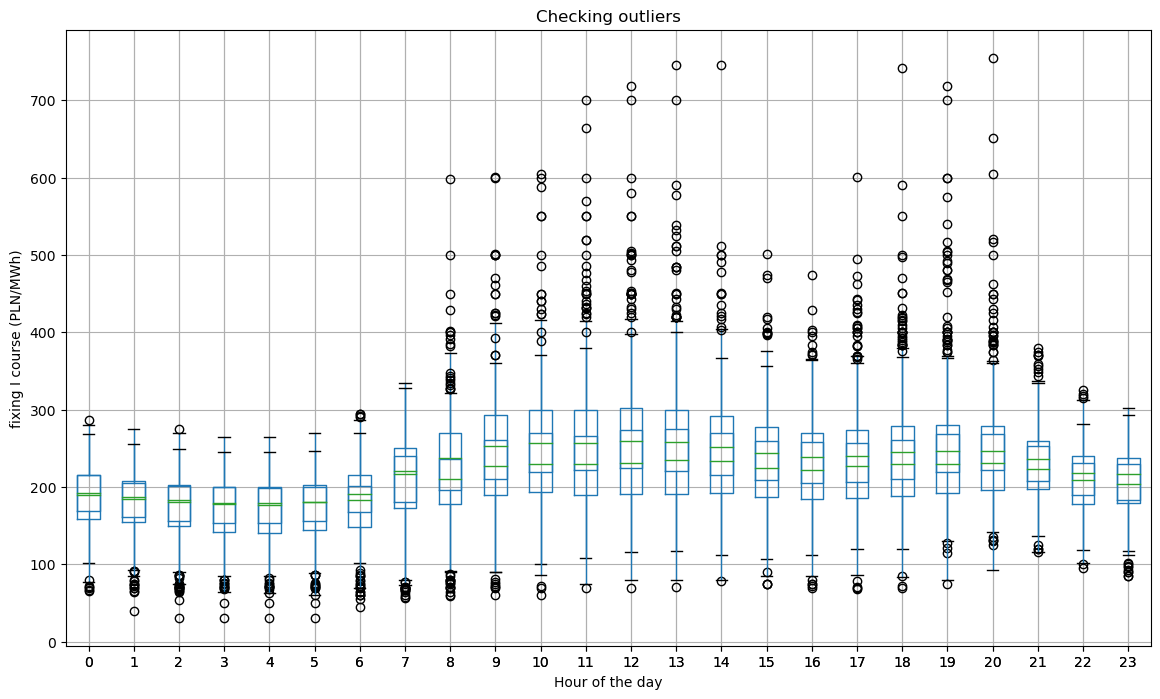

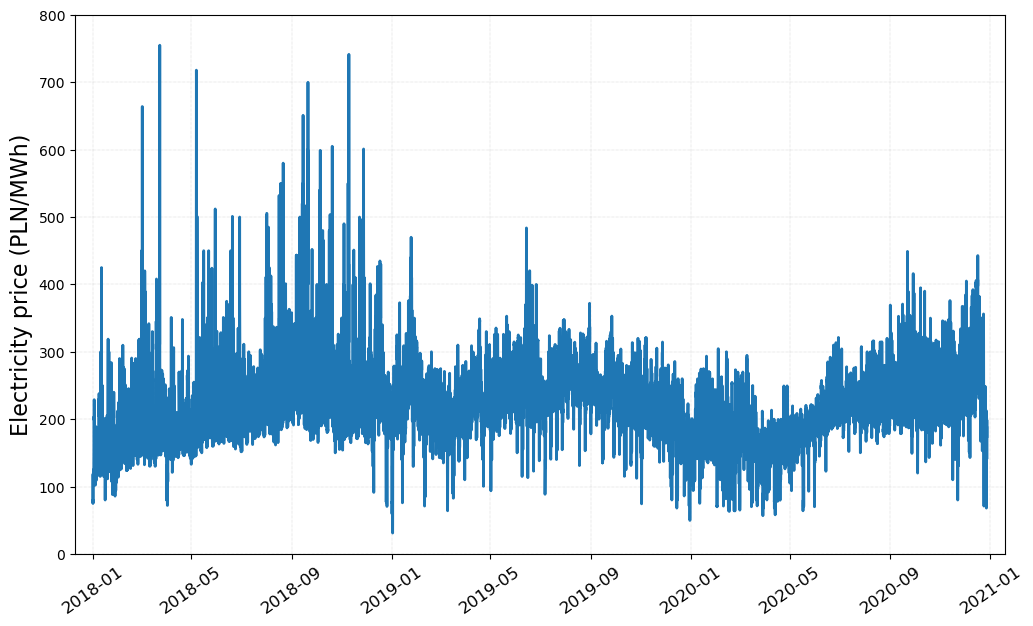

In [42]:
plt.rcParams["figure.facecolor"] = "w"
fig, ax = plt.subplots(figsize=(12,7))

plt.plot(df['date'], df['electricity_price (PLN/MWh)'], label = 'line 1',
        linewidth=2.0)


my_xticks = np.array(df['date_normalize'])
plt.ylabel("Electricity price (PLN/MWh)", fontsize=16)
plt.margins(0.02)
plt.ylim(120,270, 30)
plt.yticks(np.arange(0, 810, 100), fontsize=10)
plt.xticks(fontsize=12, rotation = 35)
plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
plt.show()

In [43]:
df_daily = df.groupby(['date_normalize']).agg({'electricity_price (PLN/MWh)':np.mean}).reset_index()

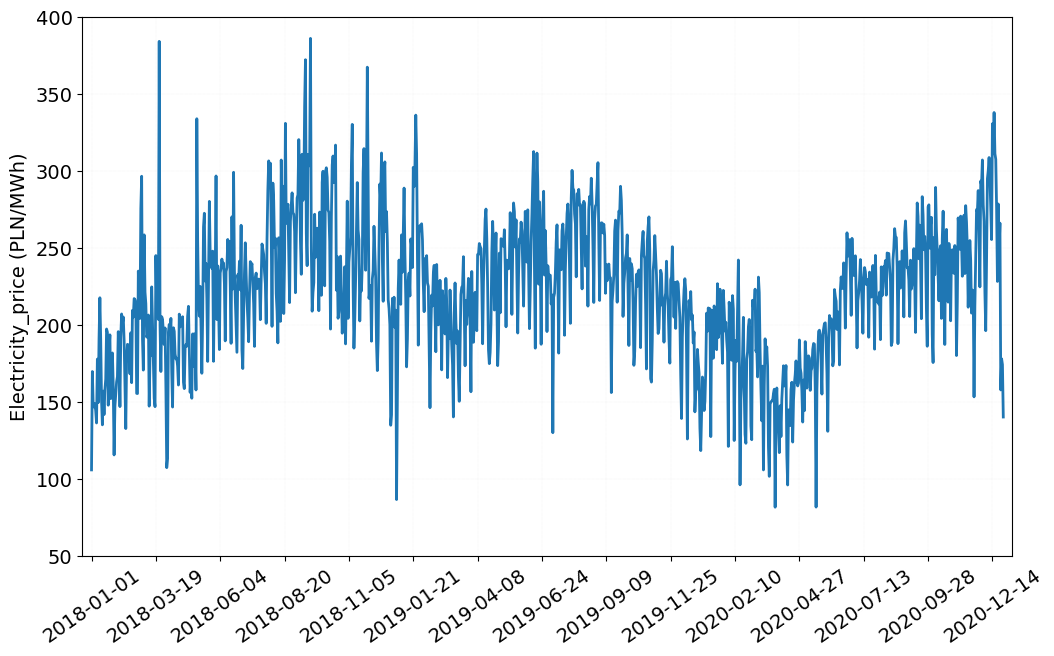

In [44]:
fig, ax = plt.subplots(figsize=(12,7))

plt.plot(df_daily['date_normalize'], df_daily['electricity_price (PLN/MWh)'], label = 'line 1', linewidth=2.0)
plt.ylabel("Electricity_price (PLN/MWh)", fontsize=14)
plt.margins(0.01)

plt.yticks(np.arange(50, 410, 50), fontsize=14)
plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.2, axis='both')
ax.set_xticks(df_daily['date_normalize'].loc[::77])
ax.set_xticklabels([label for label in df_daily['date_normalize'].loc[::77]],rotation = 35, fontsize=14)
#plt.xticks(rotation=60)
plt.savefig('fig1.png', dpi=800)
plt.show()

In [45]:
df

,date,electricity_price (PLN/MWh),energy_demand (MW),energy_from_wind_sources (MW),date_normalize,is_holiday,code_of_the_day,electricity_price (PLN/MWh) lag24,electricity_price (PLN/MWh) lag48,electricity_price (PLN/MWh) lag72,...,energy_from_wind_sources (MW) lag168,energy_from_wind_sources (MW) lag336,energy_demand (MW) lag24,energy_demand (MW) lag48,energy_demand (MW) lag72,energy_demand (MW) lag96,energy_demand (MW) lag120,energy_demand (MW) lag144,energy_demand (MW) lag168,energy_demand (MW) lag336
0,2018-01-01 01:00:00,117.00,14586,3938,2018-01-01,1,0,98.00,121.03,121.22,...,5042.0,130.0,15048.0,15984.0,16093.0,16198.0,14063.0,13451.0,13482.0,16716.0
1,2018-01-01 02:00:00,113.59,14453,3876,2018-01-01,1,0,82.00,121.03,120.00,...,5091.0,128.0,14295.0,15325.0,15383.0,15378.0,13525.0,12903.0,12995.0,16189.0
2,2018-01-01 03:00:00,97.00,13692,3897,2018-01-01,1,0,76.14,121.03,119.60,...,4999.0,119.0,14110.0,14971.0,15229.0,15136.0,13204.0,12755.0,12587.0,16108.0
3,2018-01-01 04:00:00,89.00,13329,4091,2018-01-01,1,0,74.70,121.03,119.60,...,4884.0,116.0,13961.0,14920.0,15160.0,15055.0,13243.0,12638.0,12276.0,16250.0
4,2018-01-01 05:00:00,75.00,13168,4197,2018-01-01,1,0,73.78,121.03,121.22,...,4673.0,110.0,13910.0,15013.0,15372.0,15158.0,13319.0,12787.0,12228.0,16819.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26202,2020-12-27 19:00:00,198.81,18254,5645,2020-12-27,1,1,204.91,238.56,180.00,...,2653.0,197.0,17184.0,16568.0,16697.0,24065.0,24401.0,24650.0,20594.0,20903.0
26203,2020-12-27 20:00:00,195.00,18242,5669,2020-12-27,1,1,212.91,226.30,155.10,...,2611.0,235.0,17339.0,16608.0,16535.0,23724.0,24123.0,24361.0,20472.0,20810.0
26204,2020-12-27 21:00:00,186.03,18021,5518,2020-12-27,1,1,212.91,220.44,130.00,...,2435.0,250.0,17077.0,16381.0,16286.0,23029.0,23324.0,23697.0,20087.0,20090.0
26205,2020-12-27 22:00:00,174.75,17370,5625,2020-12-27,1,1,207.89,214.67,122.77,...,2266.0,252.0,16479.0,16050.0,16124.0,21560.0,21806.0,22177.0,19237.0,19173.0


In [52]:
from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels.api as sm

def tsdisplay(y, figsize = (26, 18), title = "", lags = 168):
    tmp_data = pd.Series(y)
    fig = plt.figure(figsize = figsize)

    #Plot the PACF:
    plt.rc("figure", figsize=(13,5))
    _ = sm.graphics.tsa.plot_acf(tmp_data, lags = 168, zero = True)
    _ = plt.xticks(np.arange(0,  lags+1, 8))
    plt.title("")
    plt.xticks(rotation=30)
    plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.2, axis='both')
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=13.3)
    plt.xlabel("Lag time (Hour)", fontsize=11)
    plt.savefig('fig_2.png', dpi=800)
    plt.show()

<Figure size 2600x1000 with 0 Axes>

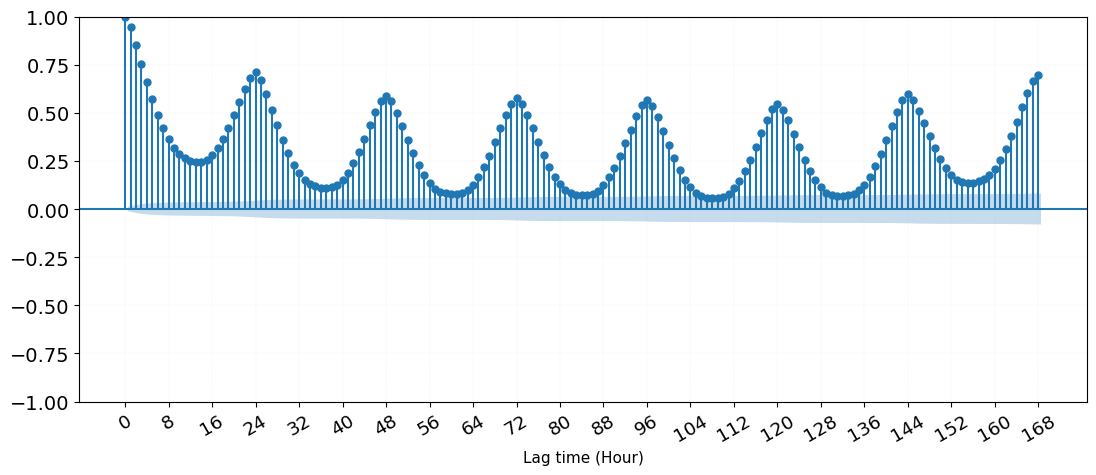

In [53]:
tsdisplay(df['electricity_price (PLN/MWh)'])